<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [ ]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb
!pip3 install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://yadi.sk/d/b4nAwIE73TVcp5) -o 'data.tar.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  843M  100  843M    0     0  9278k      0  0:01:33  0:01:33 --:--:--  9.8M


In [ ]:
!tar -xzf data.tar.gz

### Data preprocessing

In [ ]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 189 ms, sys: 383 ms, total: 572 ms
Wall time: 576 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [ ]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        word_counts.update(sentence)

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    #print(logits_for_next.shape, captions_ix_next.shape)
    
    logits_for_next = logits_for_next.reshape(-1, logits_for_next.shape[-1])
    captions_ix_next = captions_ix_next.reshape(-1)

    loss = nn.CrossEntropyLoss(ignore_index=pad_ix)(logits_for_next, captions_ix_next)
    
    return loss.reshape(-1)

In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [ ]:
network = CaptionNet(n_tokens).to(device)

In [ ]:
opt = torch.optim.Adam(network.parameters(), lr=0.001)

# Training

* First implement the batch generator
* Than train the network as usual

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device), torch.tensor(batch_captions_ix, dtype=torch.int64).to(device)
    

In [ ]:
generate_batch(img_codes,captions,3)

(tensor([[0.3996, 0.9119, 0.3517,  ..., 0.0943, 1.2211, 0.4267],
         [0.7772, 0.3058, 0.3668,  ..., 0.0195, 1.0439, 0.2591],
         [0.2800, 0.2400, 0.5828,  ..., 0.0959, 0.1333, 0.0645]],
        device='cuda:0'),
 tensor([[   1,  115,   57,  613,   18,  180,  174,  109,  186,  417,   35,   12,
             2],
         [   1,  355, 3182,  362,    6,    7, 1319,  392,  150,   12,    2,    3,
             3],
         [   1,    7, 1488,  121,   58, 3213,  137,   15,   24,    0, 1033,    2,
             3]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [ ]:
batch_size = 100  # adjust me
n_epochs = 80  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

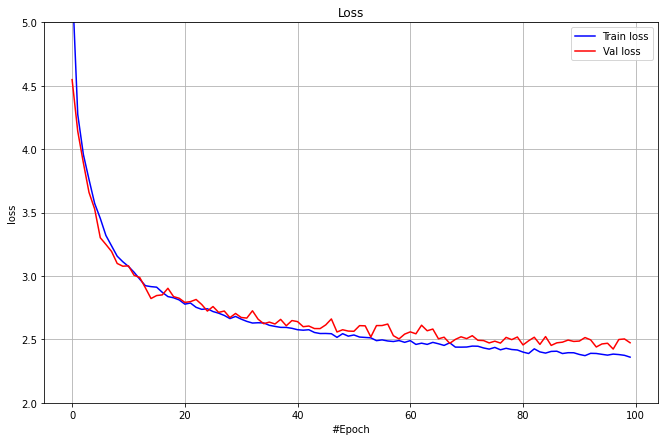

Epoch: 99, train loss: 2.359918706417084, val loss: 2.4733147859573363
Finished!


In [ ]:
from tqdm.notebook import trange
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

history = [[], []]
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in trange(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        # clear old gradients
        opt.zero_grad()

        # do a backward pass to get new gradients
        loss_t.backward()

        # then train with opt
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    history[0].append(train_loss)
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()

    val_loss /= n_validation_batches
    history[1].append(val_loss)

    display.clear_output(wait=True)
    fig = plt.figure(figsize=(11, 7))
    ax = fig.add_subplot(1, 1, 1) 
    ax.set_title("Loss")
    ax.set_xlabel("#Epoch")
    ax.set_ylabel("loss")
    ax.plot(history[0], 'b', label='Train loss')
    ax.plot(history[1], 'r', label='Val loss')
    ax.legend(loc='best')
    ax.grid()
    ax.set_ylim(2, 5)

    plt.show()

    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch + 1, train_loss, val_loss))

print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [ ]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [ ]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        vectors_neck = vectors_neck.to(device)
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2020-09-02 10:34:07--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-09-02 10:34:07--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.03s   

2020-09-02 10:34:07 (1.99 MB/s) - ‘data/img.jpg’ sa

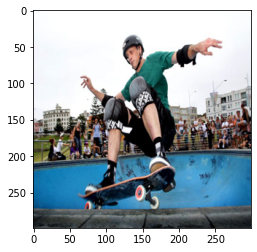

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard up the side of a ramp .
a man riding a skateboard on a skate board .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard down a rail .
a man riding a skateboard on a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up a ramp .
a man riding a skateboard up a ramp .


--2020-09-02 10:35:34--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-09-02 10:35:34--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K   187KB/s    in 0.6s    

2020-09-02 10:35:36 (187 KB/s) - ‘data/img.jpg’ saved [106870/106870]



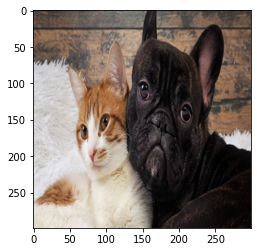

a black and white cat sitting next to a black cat .
a black and white cat sitting on a chair .
a black and white cat sitting on a chair .
a black and white cat is sitting on a chair .
a black and white cat sitting on a chair .
a black and white cat sitting on a chair .
a black and white cat sitting on a chair .
a black and white cat laying on a white blanket .
a black and white cat sitting on a wooden bench .
a black and white cat sitting on a wooden bench .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [ ]:
!mkdir -p data/imgs

!wget -q https://cdn.pixabay.com/photo/2020/08/22/12/35/doe-5508334_1280.jpg -O data/imgs/img1.jpg
!wget -q https://cdn.pixabay.com/photo/2015/11/16/16/28/bird-1045954_1280.jpg -O data/imgs/img2.jpg
!wget -q https://cdn.pixabay.com/photo/2016/01/08/11/57/butterfly-1127666_1280.jpg -O data/imgs/img3.jpg
!wget -q https://cdn.pixabay.com/photo/2018/07/21/03/55/girl-3551832_1280.jpg -O data/imgs/img4.jpg
!wget -q https://cdn.pixabay.com/photo/2013/06/29/21/18/wolf-142173_1280.jpg -O data/imgs/img5.jpg
!wget -q https://cdn.pixabay.com/photo/2016/03/23/04/01/beautiful-1274056_1280.jpg -O data/imgs/img6.jpg
!wget -q https://cdn.pixabay.com/photo/2017/06/07/10/47/elephant-2380009_1280.jpg -O data/imgs/img7.jpg
!wget -q https://cdn.pixabay.com/photo/2018/01/24/19/49/people-3104635_1280.jpg -O data/imgs/img8.jpg
!wget -q https://cdn.pixabay.com/photo/2016/03/09/09/22/workplace-1245776_1280.jpg -O data/imgs/img9.jpg
!wget -q https://cdn.pixabay.com/photo/2014/05/02/21/50/home-office-336378_1280.jpg -O data/imgs/img10.jpg

!ls data/imgs | wc -l

10


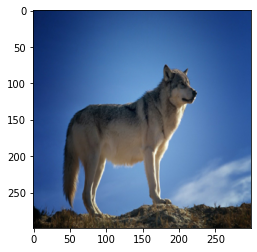

a large brown and black bear walking across a field .
a group of people standing on a beach next to a dog .
a group of people are standing on a beach .
a group of people standing on top of a beach .
a group of people standing on top of a sandy beach .
a couple of animals that are standing in the grass .
a group of people standing on a beach .
a couple of people are standing on a beach
a couple of animals that are standing in the grass .
a dog is laying on the beach with a frisbee in his hand .




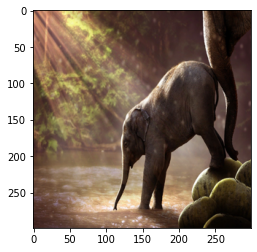

a black bear is laying on the ground in the woods .
a black bear is standing on a rock .
a black bear is standing on a rock in a field .
a bear is standing in the dirt with its trunk .
a black bear is laying on a dirt ground .
a bear is standing in the middle of a dirt road .
a bear is standing on the ground in the woods .
a black bear is standing on the ground .
a black bear is standing in the dirt .
a black bear laying on top of a dirt road .




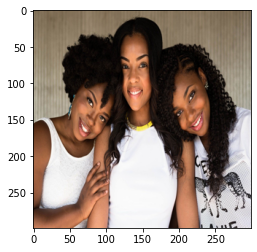

a woman and a woman are posing for a picture .
a woman and a woman pose for a picture .
a woman and a woman are posing for a picture .
a woman is posing for a picture with her phone .
a woman and a woman are posing for a picture .
a woman and a woman are posing for a picture .
a woman is posing for a picture with her phone .
a woman and a woman pose for a picture .
a woman and a woman are posing for a picture .
a woman and a woman pose for a picture .




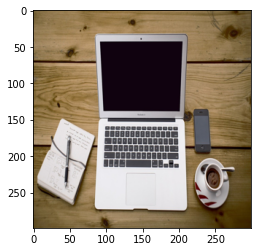

a computer desk with a computer and a keyboard .
a laptop computer sitting on top of a wooden desk .
a computer monitor sitting on top of a wooden desk .
a computer monitor and a mouse on a desk .
a laptop computer sitting on top of a wooden desk .
a computer desk with a computer and a mouse .
a computer desk with a laptop computer sitting on it .
a computer monitor sitting on top of a wooden desk .
a laptop computer sitting on top of a wooden desk .
a computer desk with a laptop and a mouse .




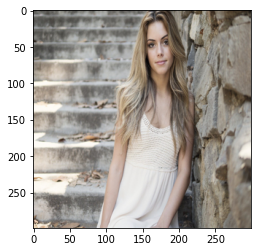

a woman in a black jacket is holding a cell phone .
a woman with a black and white shirt and a woman .
a woman is posing with a glass of wine .
a woman in a white dress is holding a cell phone .
a woman is holding a glass of wine .
a woman with glasses is holding a cell phone .
a woman in a white dress shirt and a black and white dress and a black shirt .
a woman in a dress is holding a cell phone .
a woman is holding a cell phone in her hand .
a woman in a white dress holding a glass of wine .




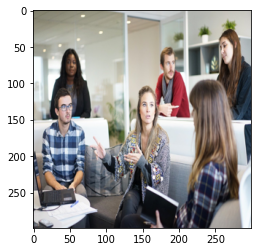

a group of people sitting around a table with a laptop .
a woman sitting at a table with a laptop and a laptop .
a group of people sitting around a table with a laptop .
a group of people sitting around a table with a laptop .
a woman sitting at a table with a laptop and a laptop .
a group of people sitting around a table with a laptop .
a group of people sitting around a table with a laptop .
a group of people sitting around a table .
a group of people sitting around a table with a laptop .
a woman sitting at a table with a laptop computer .




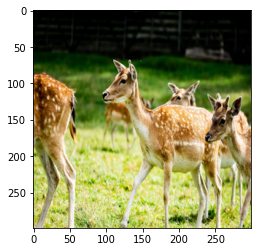

a giraffe is standing in a field of tall grass .
a giraffe standing in a grassy area with trees in the background .
a giraffe standing in a field of grass .
a giraffe is standing in a field of tall grass .
a giraffe standing in a field of tall grass .
a giraffe is standing in a field of tall grass .
a giraffe standing in a field with a large tree in the background .
a giraffe standing in a field of tall grass .
a giraffe standing in a field of tall grass .
a giraffe is standing in a field of tall grass .




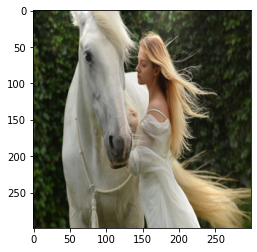

a woman is holding a frisbee in her hand .
a woman is holding a frisbee in her hand .
a woman is playing with a frisbee in a field .
a woman is holding a frisbee in her hand .
a woman in a white shirt is playing frisbee
a woman is holding a frisbee in her hand .
a woman is holding a frisbee in her hand .
a woman is holding a frisbee in her hand .
a woman is holding a frisbee in her hand .
a woman is holding a frisbee in her hand .




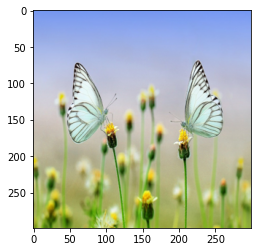

a close up of a bird flying in the air
a close up of a bird flying in the air
a large bird flying through the air with a tree branch .
a small bird flying in the air above a tree .
a large bird is sitting on a branch .
a large bird flying over a tree branch .
a close up of a bird flying in the air
a large bird is sitting on a branch .
a large bird flying over a tree branch .
a large bird sitting on top of a tree branch .




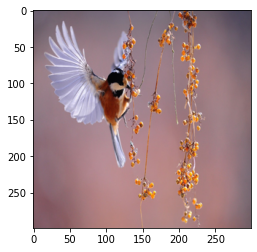

a small bird standing on top of a tree branch .
a small bird standing on top of a tree branch .
a small bird standing in the middle of a tree .
a small bird standing on top of a tree branch .
a small bird standing on a tree branch .
a small bird standing on top of a tree branch .
a small bird is standing on a tree branch .
a bird is standing on a tree branch
a small bird standing on a tree branch .
a small bird standing on top of a tree branch .




In [ ]:
import glob

for path in glob.glob('data/imgs/*'):
    img = plt.imread(path)
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

    #print(path)
    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))
    print('\n')